In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

# import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

In [2]:
tweets = pd.read_csv("../data/cyberbullying_tweets.csv")

## EDA

In [3]:
print(tweets.shape)

(47692, 2)


In [4]:
tweets.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

<AxesSubplot:ylabel='cyberbullying_type'>

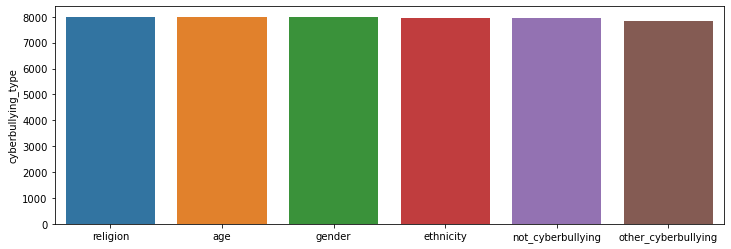

In [6]:
plt.figure(figsize=(12,4))
sns.barplot(x=tweets['cyberbullying_type'].value_counts().index, y=tweets['cyberbullying_type'].value_counts())

## Data Preprocessing

### Extract hashtags, mentions, links and emojis

In [1]:
def extract_hashtags(self):
    regex = "#(\w+)"
    hashtag_list = re.findall(regex, self)
    l=[]
    for x in hashtag_list:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(hashtag_list) > 0:
        return ' '.join(hashtag_list)
    else:
        return ''

def extract_tags(self):
    regex = "@(\w+)"
    name_tag = re.findall(regex, self)
    l=[]
    for x in name_tag:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(l) > 0:
        return ' '.join(l)
    else:
        return ''

def extract_links(self):
    regex = r'(https?://\S+)'
    url_list = re.findall(regex, self)
    l=[]
    for x in url_list:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(url_list) > 0:
        return ' '.join(url_list)
    else:
        return ''

def extract_emojis(self):
    emoji_list = ''.join(c for c in self if c in emoji.UNICODE_EMOJI['en'])
    text_emoji =  ''.join(emoji.demojize(x) for x in emoji_list if x)
    regex = r"\:(.*?)\:"
    text_emoji =  re.findall(regex, text_emoji)
    if len(text_emoji) > 0:
        return ' '.join(text_emoji)
    else:
        return ''

In [ ]:
tweets['tweet_text'] = tweets['tweet_text'].str.lower()
tweets['hash_tag']   = tweets['tweet_text'].apply(extract_hashtags)
tweets['name_tag']   = tweets['tweet_text'].apply(extract_tags)
tweets['url_tag']    = tweets['tweet_text'].apply(extract_links)
tweets['emoji_tag']  = tweets['tweet_text'].apply(extract_emojis)

### Remove the symbols and numbers from tweet text

In [ ]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: re.sub(r"[^a-zA-Z ]+", '', x))

### Remove the hashtags, mentions, url and emojis from tweet text

In [2]:
def clean_text(text,dirt):
    dirt = dirt.split()
    for x in dirt:
        text = text.replace(x,'')
        text = " ".join(text.split())
    return text

In [ ]:
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['name_tag']),axis=1)
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['hash_tag']),axis=1)
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['url_tag']),axis=1)

### Process the tweets

In [3]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('à', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [ ]:
STOPWORDS = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [ ]:
def clean_tweet(text):
    # Remove Hashtag, Mention, https, www.asdfd, dsfadsf.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', str(text))
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Replace accented letters
    text = normalize_accent(text)

    # Lemmatize word and remove stopwords
    text = " ".join([lemma.lemmatize(word) for word in str(text).split() if word.isalpha() and word not in STOPWORDS])

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [ ]:
tweets['clean_tweet'] = tweets['tweet_text']
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda text: clean_tweet(text))

In [ ]:
# tweets.to_csv("../data/cleaned_cyberbullying_tweets.csv", index=False)

## WordCloud

In [ ]:
# for s in list(tweets.cyberbullying_type.value_counts().index):
#     plt.figure(figsize=(10,10))
#     wordcloud = WordCloud(min_font_size=5, max_words=1000, width=1600 , height=800 , stopwords=STOPWORDS).generate(str(tweets[tweets["cyberbullying_type"] == s].clean_tweet))
#     plt.axis('off')
#     plt.imshow(wordcloud)
#     plt.title(s)
#     plt.show()

## TFIDF

In [ ]:
tweets = pd.read_csv("../data/cleaned_cyberbullying_tweets.csv")
tweets.hash_tag = tweets.hash_tag.fillna("")
tweets.emoji_tag = tweets.emoji_tag.fillna("")
tweets.clean_tweet = tweets.clean_tweet.fillna("")

In [ ]:
hshtg_vectorizer = TfidfVectorizer() #max_features=1000
hshtg_vec = hshtg_vectorizer.fit_transform(tweets.hash_tag)
print(hshtg_vec.shape)
# print(hshtg_vectorizer.get_feature_names())
tfidf_hashtags = hshtg_vectorizer.get_feature_names()

hshtg_tfidf = pd.DataFrame(hshtg_vec.todense(), columns=tfidf_hashtags)

In [ ]:
emoji_vectorizer = TfidfVectorizer()
emoji_vec = emoji_vectorizer.fit_transform(tweets.emoji_tag)
print(emoji_vec.shape)
# print(emoji_vectorizer.get_feature_names())

tfidf_emojis = emoji_vectorizer.get_feature_names()

emoji_tfidf = pd.DataFrame(emoji_vec.todense(), columns=tfidf_emojis)

In [ ]:
tfidf_vec = TfidfVectorizer(min_df=.0005, max_df=.90)
tfidf = tfidf_vec.fit_transform(tweets.clean_tweet)
print(tfidf.shape)
tfidf_tweet_terms = tfidf_vec.get_feature_names()

tweets_tfidf = pd.DataFrame(tfidf.todense(), columns=tfidf_tweet_terms)

In [ ]:
print(hshtg_tfidf.shape)
print(emoji_tfidf.shape)
print(tweets_tfidf.shape) # total 7810 columns

In [ ]:
final_tweets = pd.concat([tweets[['tweet_text','cyberbullying_type']], tweets_tfidf, hshtg_tfidf, emoji_tfidf], axis=1)
print(final_tweets.shape)

In [ ]:
final_tweets = final_tweets.loc[:,~final_tweets.columns.duplicated()]
print(final_tweets.shape)

In [14]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('à', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [15]:
STOPWORDS = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [16]:
def clean_tweet(text):
    # Remove Hashtag, Mention, https, www.asdf, zxcv.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', str(text))
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Replace accented letters
    text = normalize_accent(text)

    # Lemmatize word and remove stopwords
    text = " ".join([lemma.lemmatize(word) for word in str(text).split() if word.isalpha() and word not in STOPWORDS])

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [19]:
tweets['clean_tweet'] = tweets['tweet_text']
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda text: clean_tweet(text))
tweets.head()

,tweet_text,cyberbullying_type,clean_tweet
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy red velvet
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,thanks head concerned another angry dude
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish like


In [20]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
clean_tweet           0
dtype: int64

In [26]:
tweets["cyberbullying_type_binary"] = np.where(tweets["cyberbullying_type"] == "not_cyberbullying", 'not_cyberbullying', 'cyberbullying')

In [27]:
tweets.to_csv("../data/cleaned_cyberbullying_tweets.csv")

In [41]:
tweets['hashtag'] = tweets['tweet_text'].apply(lambda x: re.findall(r'#(\w+)', x))
tweets['mentions'] = tweets['tweet_text'].apply(lambda x: [ w[1]for w in re.findall(r"(^|[^@\w])@(\w{1,15})", x)])


,tweet_text,cyberbullying_type,clean_tweet,cyberbullying_type_binary,hashtag,mentions
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food,not_cyberbullying,"[katandandre, mkr]",[]
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,,not_cyberbullying,"[aussietv, MKR, theblock, ImACelebrityAU, toda...",[]
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy red velvet,not_cyberbullying,[],[XochitlSuckkks]
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,thanks head concerned another angry dude,not_cyberbullying,[],[Jason_Gio]
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish like,not_cyberbullying,[],[RudhoeEnglish]


In [42]:
tweets.head(30)

,tweet_text,cyberbullying_type,clean_tweet,cyberbullying_type_binary,hashtag,mentions
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food,not_cyberbullying,"[katandandre, mkr]",[]
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,,not_cyberbullying,"[aussietv, MKR, theblock, ImACelebrityAU, toda...",[]
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy red velvet,not_cyberbullying,[],[XochitlSuckkks]
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,thanks head concerned another angry dude,not_cyberbullying,[],[Jason_Gio]
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish like,not_cyberbullying,[],[RudhoeEnglish]
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,test god good bad indifferent weird prof god,not_cyberbullying,[],"[Raja5aab, Quickieleaks]"
6,Itu sekolah ya bukan tempat bully! Ga jauh kay...,not_cyberbullying,itu sekolah ya bukan tempat ga jauh kaya neraka,not_cyberbullying,[],[]
7,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,hope bite kat,not_cyberbullying,[mkr],[]
8,@stockputout everything but mostly my priest,not_cyberbullying,everything mostly priest,not_cyberbullying,[],[stockputout]
9,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,rebecca black drop school due,not_cyberbullying,[],[]


## WordCloud

In [44]:
from wordcloud import WordCloud

In [45]:
# for s in list(tweets.cyberbullying_type.value_counts().index):
#     plt.figure(figsize=(10,10))
#     wordcloud = WordCloud(min_font_size=5, max_words=1000, width=1600 , height=800 , stopwords=STOPWORDS).generate(str(tweets[tweets["cyberbullying_type"] == s].clean_tweet))
#     plt.axis('off')
#     plt.imshow(wordcloud)
#     plt.title(s)
#     plt.show()

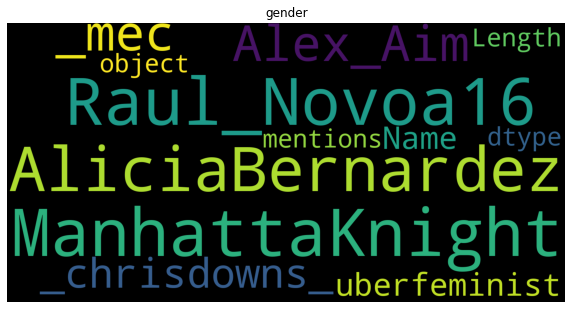

In [48]:
s = "gender"
plt.figure(figsize=(10,10))
wordcloud = WordCloud(min_font_size=5, max_words=1000, width=1600 , height=800 , stopwords=STOPWORDS).generate(str(tweets[tweets["cyberbullying_type"] == s].hashtag))
plt.axis('off')
plt.imshow(wordcloud)
plt.title(s)
plt.show()